In [2]:
!pip install backpack-for-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import copy
import tqdm

In [4]:
# Create base images (happy, sad, neutral faces)
def create_base_images():
    base_images = np.zeros((3, 16, 16))
    # Happy face (index 0)
    base_images[0, 4, 4] = base_images[0, 4, 11] = 1  # Eyes
    base_images[0, 10, 5:11] = 1  # Smile (curved upwards)
    base_images[0, 11, 4] = base_images[0, 11, 11] = 1  # Smile curve corners
    base_images[0, 12, 3] = base_images[0, 12, 12] = 1  # Smile curve corners

    # Sad face (index 1)
    base_images[1, 4, 4] = base_images[1, 4, 11] = 1  # Eyes
    base_images[1, 11, 5:11] = 1  # Frown (curved downwards)
    base_images[1, 10, 4] = base_images[1, 10, 11] = 1  # Smile curve corners
    base_images[1, 9, 3] = base_images[1, 9, 12] = 1  # Smile curve corners

    # Neutral face (index 2)
    base_images[2, 4, 4] = base_images[2, 4, 11] = 1  # Eyes
    base_images[2, 10, 4:12] = 1  # Straight line for mouth

    return base_images

# Generate noisy dataset
def generate_dataset(base_images, label=-1, num_samples=3000, noise_level=0.2):
    images = []
    labels = []
    in_label=label
    for i in range(num_samples):
        if in_label == -1:
            label = np.random.randint(0, 3)
        img = base_images[label] + noise_level * np.random.randn(16, 16)
        img = np.clip(img, 0, 1)  # Keep pixel values between 0 and 1
        images.append(img)
        labels.append(label)
    return torch.tensor(images, dtype=torch.float64).unsqueeze(1), torch.tensor(labels, dtype=torch.long)

# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute Hessian
def compute_hessian(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for grad in grad_params:
        grad_vector = grad.view(-1)
        row = []
        for g in grad_vector:
            second_derivative = torch.autograd.grad(g, model.parameters(), retain_graph=True)
            row.append(torch.cat([sd.contiguous().view(-1) for sd in second_derivative]))
        hessian.append(torch.stack(row))
    return torch.cat(hessian, dim=0)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [5]:
# Main execution

base_images = create_base_images()
n_samples = 3000
images_h, labels_h = generate_dataset(base_images, label=0, num_samples=n_samples//3)
images_s, labels_s = generate_dataset(base_images, label=1, num_samples=n_samples//3)
images_n, labels_n = generate_dataset(base_images, label=2, num_samples=n_samples//3)
train_dataset_h = TensorDataset(images_h, labels_h)
train_dataset_s = TensorDataset(images_s, labels_s)
train_dataset_n = TensorDataset(images_n, labels_n)

train_dataset = train_dataset_h + train_dataset_s + train_dataset_n
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_dataset_unp = train_dataset_h + train_dataset_n
train_loader_unp = DataLoader(train_dataset_unp, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),                    # Flatten the 16x16x16 feature map
    nn.Linear(16 * 16 * 16, 64),
    nn.ReLU(),
    nn.Linear(64, 3)                 # 3 classes
)
model = extend(model)
model.double()
model_unp = copy.deepcopy(model)

criterion = nn.CrossEntropyLoss()
criterion_unp = nn.CrossEntropyLoss()
lossfunc = extend(criterion)
lossfunc_unp = extend(criterion_unp)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_unp = optim.Adam(model_unp.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, epochs=7)
train(model_unp, train_loader_unp, criterion_unp, optimizer_unp, epochs=7)

<ipython-input-4-c356e55438ad>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(images, dtype=torch.float64).unsqueeze(1), torch.tensor(labels, dtype=torch.long)


Epoch [1/7], Loss: 0.0026
Epoch [2/7], Loss: 0.0003
Epoch [3/7], Loss: 0.0001
Epoch [4/7], Loss: 0.0000
Epoch [5/7], Loss: 0.0000
Epoch [6/7], Loss: 0.0000
Epoch [7/7], Loss: 0.0000
Epoch [1/7], Loss: 0.0350
Epoch [2/7], Loss: 0.0025
Epoch [3/7], Loss: 0.0005
Epoch [4/7], Loss: 0.0003
Epoch [5/7], Loss: 0.0001
Epoch [6/7], Loss: 0.0000
Epoch [7/7], Loss: 0.0000


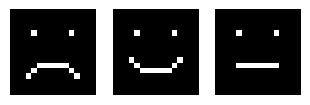

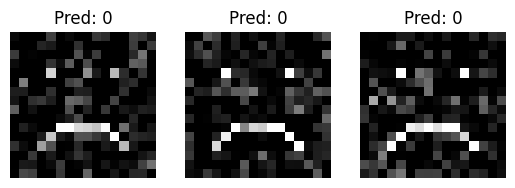

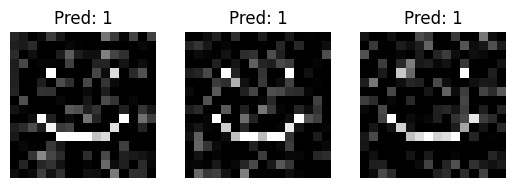

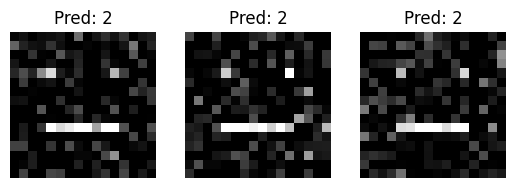

In [6]:
# Test model on some samples
test_samples_h, _ = generate_dataset(base_images, label=0, num_samples=3)
test_samples_s, _ = generate_dataset(base_images, label=1, num_samples=3)
test_samples_n, _ = generate_dataset(base_images, label=2, num_samples=3)
test_samples = torch.cat((test_samples_h, test_samples_s, test_samples_n), dim=0)

with torch.no_grad():
    predictions = model(test_samples).argmax(dim=1)

# Show some test images
for i in range(3):
    plt.subplot(1, 5, i+1)
    plt.imshow(base_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# Show some test images
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[3+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[3+i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[6+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[6+i].item()}')
    plt.axis('off')
plt.show()

In [7]:
half_sample_percentage = 50
half_num_samples = int(len(images_s) * half_sample_percentage / 100)

model.eval()
train_images=torch.cat([images_h,images_s,images_n])
train_labels=torch.cat([labels_h,labels_s,labels_n])
half_images = torch.cat([images_h,images_n,images_s[:half_num_samples]])
half_labels = torch.cat([labels_h,labels_n,labels_s[:half_num_samples]])
unp_images = torch.cat([images_h,images_n])
unp_labels = torch.cat([labels_h,labels_n])

def compute_hessian(model):
    #Compute the Hessian with poisoned dataset
    loss = lossfunc(model(train_images), train_labels)

    with backpack(DiagHessian()):
        loss.backward(retain_graph=True)
    hessian = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h


    #Compute the Hessian with half poisoned dataset
    loss_half = lossfunc(model(half_images), half_labels)

    with backpack(DiagHessian()):
        loss_half.backward()
    hessian_half = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h

    #Compute the Hessian with unpoisoned dataset
    loss_unp = lossfunc(model(unp_images), unp_labels)

    with backpack(DiagHessian()):
        loss_unp.backward()
    hessian_unp = [p.diag_h.clone() for p in model.parameters()]

    return hessian,hessian_half,hessian_unp


In [8]:
def compute_der(tensor1, tensor2):
    #Compute first derivative integrals of FI
    ratio = tensor1/tensor2
    return torch.log(ratio)+ 1/2 * (1-torch.pow(ratio,2))

def compute_info(hessian, hessian_half, hessian_unp):

    information = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information):
        #Compute second derivative integrals of FI
        der1 = compute_der(hessian_half[i], hessian[i])
        der2 = compute_der(hessian_unp[i], hessian_half[i])
        information[i]= torch.nan_to_num((der2-der1)/(np.power(n_samples/2,2)))

    information_quad = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information_quad):
        ratio = hessian_unp[i]/hessian[i]
        A = torch.log(ratio)
        B = 1/2 * (1-torch.pow(ratio,2))
        information_quad[i]=torch.pow(A,2) + 3/4 * torch.pow(B,2) + A*B
        information_quad[i] = torch.nan_to_num(information_quad[i]/n_samples)

    #Compute relative differences(just for testing and studying)
    delta = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(delta):
        delta[i] = torch.nan_to_num((1/hessian_unp[i]-1/hessian[i])/(1/hessian[i]))

    return information, information_quad, delta

In [9]:
def compute_true_info(hessian, hessian_half, hessian_unp):
    information_true = [torch.empty_like(p) for p in hessian]
    A_list = [torch.empty_like(p) for p in hessian]
    B_list = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(A_list):
        ratio = torch.where(torch.logical_and(hessian[i]==0, hessian_unp[i]==0), 1, hessian_unp[i]/hessian[i])
        A=torch.log(ratio)/half_num_samples
        B=(1/2 * (1-torch.pow(ratio,2)))/half_num_samples
        A[torch.isinf(A)]=0
        B[torch.isinf(B)]=0
        print(f"AND: {len(torch.nonzero(torch.logical_and(hessian[i]==0, hessian_unp[i]==0)))}")
        print(f"POISON: {len(torch.nonzero(torch.logical_and(hessian[i]==0, (hessian_unp[i]==0)==False)))}")
        print(f"UNPOISON: {len(torch.nonzero(torch.logical_and(hessian_unp[i]==0, (hessian[i]==0)==False)))}")
        A_list[i]=torch.nan_to_num(A)
        B_list[i]=torch.nan_to_num(B)

    A_flat = torch.cat([A.flatten() for A in A_list])
    B_flat = torch.cat([B.flatten() for B in B_list])

    torch.cuda.empty_cache()
    device = torch.device("cuda")
    A_flat = A_flat.to(device)
    B_flat = B_flat.to(device)
    information_true = [torch.empty_like(p).to(device) for p in hessian]
    hessian = [p.to(device) for p in hessian]
    hessian_unp = [p.to(device) for p in hessian_unp]

    information_true_view = [p.view(-1) for p in information_true]
    A_list_view = [p.view(-1) for p in A_list]
    B_list_view = [p.view(-1) for p in B_list]
    num_params = sum([p.numel() for p in hessian])
    track=0
    print("\nstart")
    for i,_ in enumerate(information_true_view):
        for j,_ in enumerate(information_true_view[i]):
            if (track+j)%(num_params//10)==0:
                print((track+j)//(num_params//100))

            temp=A_list_view[i][j]*A_flat + B_list_view[i][j]*B_flat + A_list_view[i][j]*B_flat + B_list_view[i][j]*A_flat
            information_true_view[i][j] = torch.sum(temp)+2*torch.pow(B_list_view[i][j],2)
        track+=information_true[i].numel()

    return information_true

In [10]:
info,info_quad,delt = compute_info(*compute_hessian(model))
info_unp,info_quad_unp,delt_unp = compute_info(*compute_hessian(model_unp))
info_true = compute_true_info(*compute_hessian(model))
info_true_unp = compute_true_info(*compute_hessian(model_unp))

AND: 9
POISON: 0
UNPOISON: 0
AND: 1
POISON: 0
UNPOISON: 0
AND: 270
POISON: 0
UNPOISON: 0
AND: 2
POISON: 0
UNPOISON: 0
AND: 147456
POISON: 0
UNPOISON: 0
AND: 32
POISON: 0
UNPOISON: 0
AND: 96
POISON: 0
UNPOISON: 0
AND: 0
POISON: 0
UNPOISON: 0

start
0
10
20
30
40
50
60
70
80
90
100
AND: 9
POISON: 0
UNPOISON: 0
AND: 1
POISON: 0
UNPOISON: 0
AND: 218
POISON: 0
UNPOISON: 1
AND: 1
POISON: 0
UNPOISON: 0
AND: 161396
POISON: 0
UNPOISON: 19
AND: 36
POISON: 0
UNPOISON: 0
AND: 108
POISON: 0
UNPOISON: 0
AND: 0
POISON: 0
UNPOISON: 0

start
0
10
20
30
40
50
60
70
80
90
100


True information
115785
Number of outliers: 23158


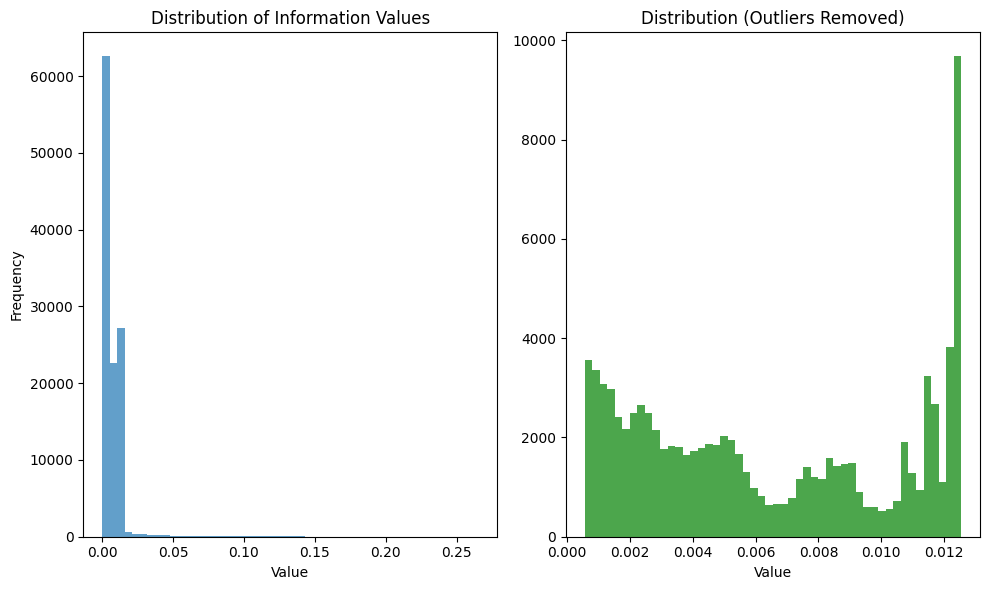

Sum of all information values: 820.623427
Mean: 0.0070874761546927895
Min: 5.919722614950358e-12
Max: 0.2651620032537187
Total number of values: 115785
Sum of all information values: 590.709709
Mean: 0.006377295052888738
Min: 0.0005546986051663177
Max: 0.012546222544459598
Total number of values: 92627
101882
Number of outliers: 18448


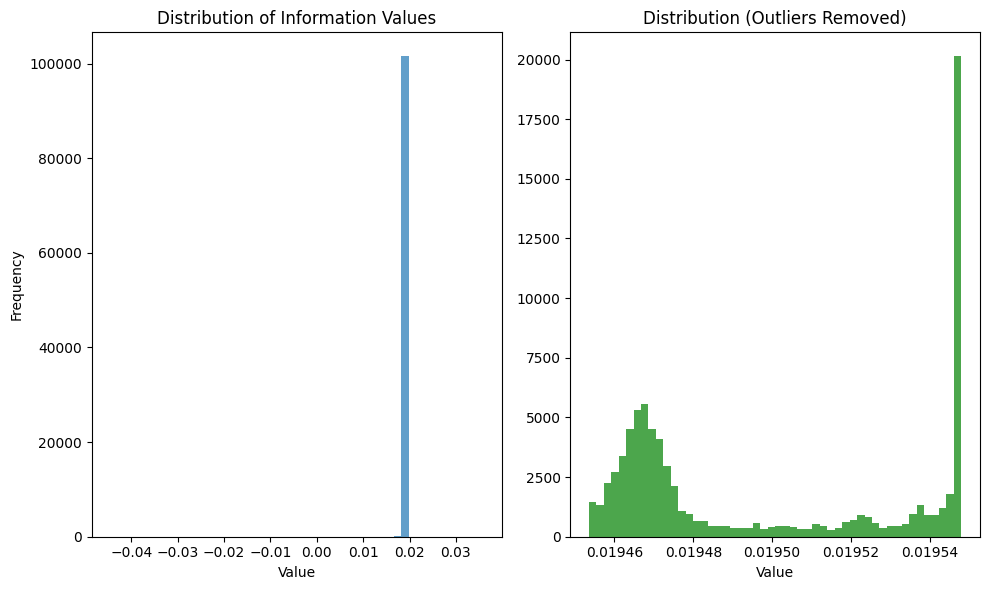

Sum of all information values: 1981.846899
Mean: 0.019452375285701026
Min: -0.04451238233787798
Max: 0.03585531617381866
Total number of values: 101882
Sum of all information values: 1626.927214
Mean: 0.019499571081585475
Min: 0.01945349760330412
Max: 0.019548045228355793
Total number of values: 83434


(1981.8468988577922, 1626.9272136210025)

In [11]:
# 1. Sum all values in the information dictionary
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

# 2. Plot the summed information
def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, bins=50, alpha=0.7)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [15, 95])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, bins=50, alpha=0.7, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

# Call the plotting function
#plot_information(info)
#plot_information(info_unp)
#print("Delta")
#plot_information(delt)
#plot_information(delt_unp)
#print("Quad information")
#plot_information(info_quad)
#plot_information(info_quad_unp)
print("True information")
plot_information(info_true)
plot_information(info_true_unp)

Preparing datasets...
Computing Fisher Information for full dataset...
Computing Fisher Information...
Processing batch 0/94
Processing batch 5/94
Processing batch 10/94
Processing batch 15/94
Processing batch 20/94
Processing batch 25/94
Processing batch 30/94
Processing batch 35/94
Processing batch 40/94
Processing batch 45/94
Processing batch 50/94
Processing batch 55/94
Processing batch 60/94
Processing batch 65/94
Processing batch 70/94
Processing batch 75/94
Processing batch 80/94
Processing batch 85/94
Processing batch 90/94
Computing Fisher Information without 'sad'...
Computing Fisher Information...
Processing batch 0/63
Processing batch 5/63
Processing batch 10/63
Processing batch 15/63
Processing batch 20/63
Processing batch 25/63
Processing batch 30/63
Processing batch 35/63
Processing batch 40/63
Processing batch 45/63
Processing batch 50/63
Processing batch 55/63
Processing batch 60/63
Computing Fisher Information for class 'happy'...
Computing Fisher Information...
Proce

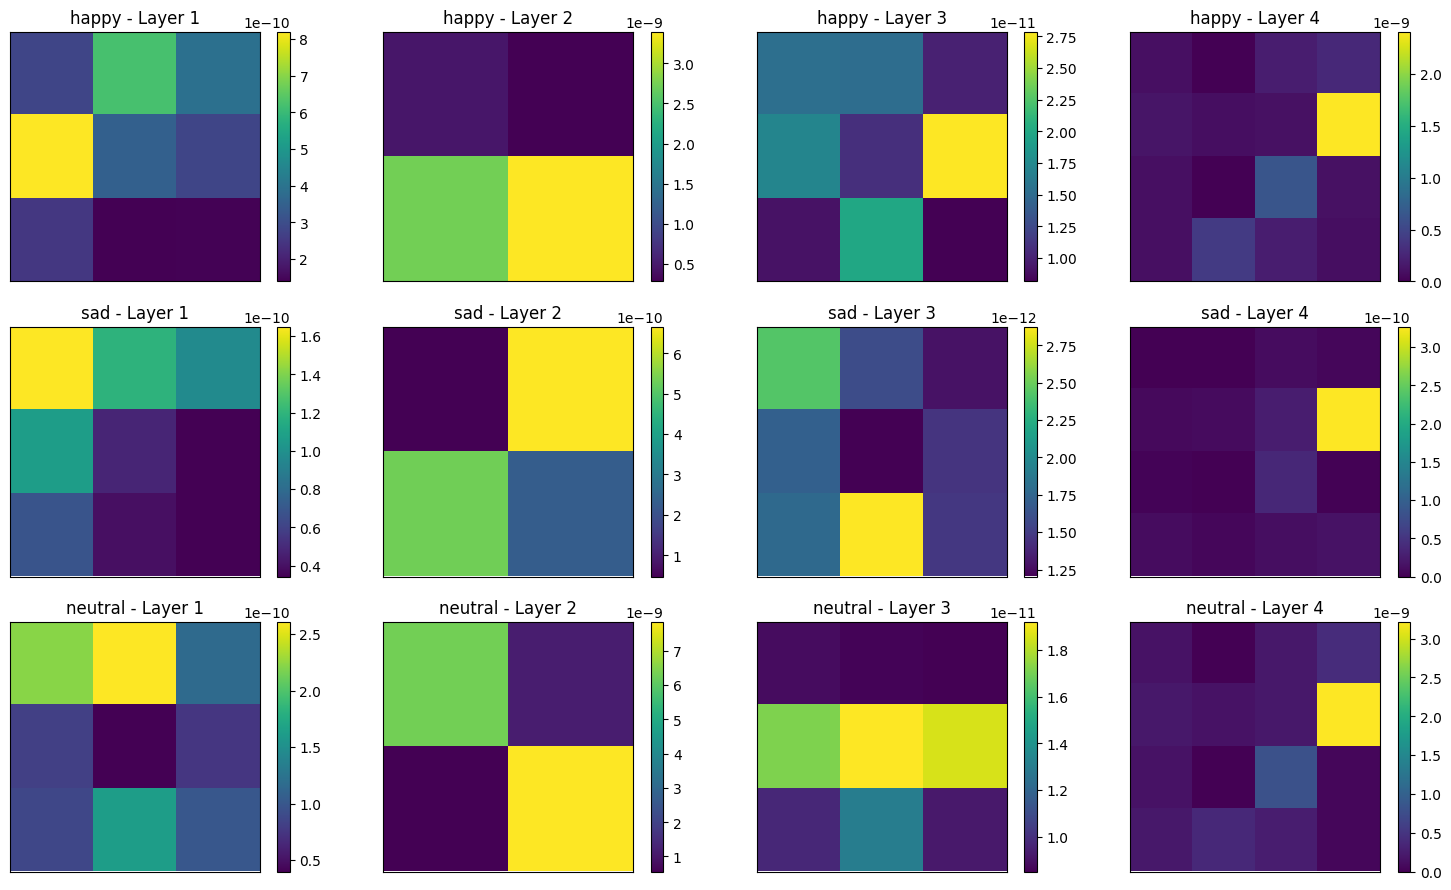

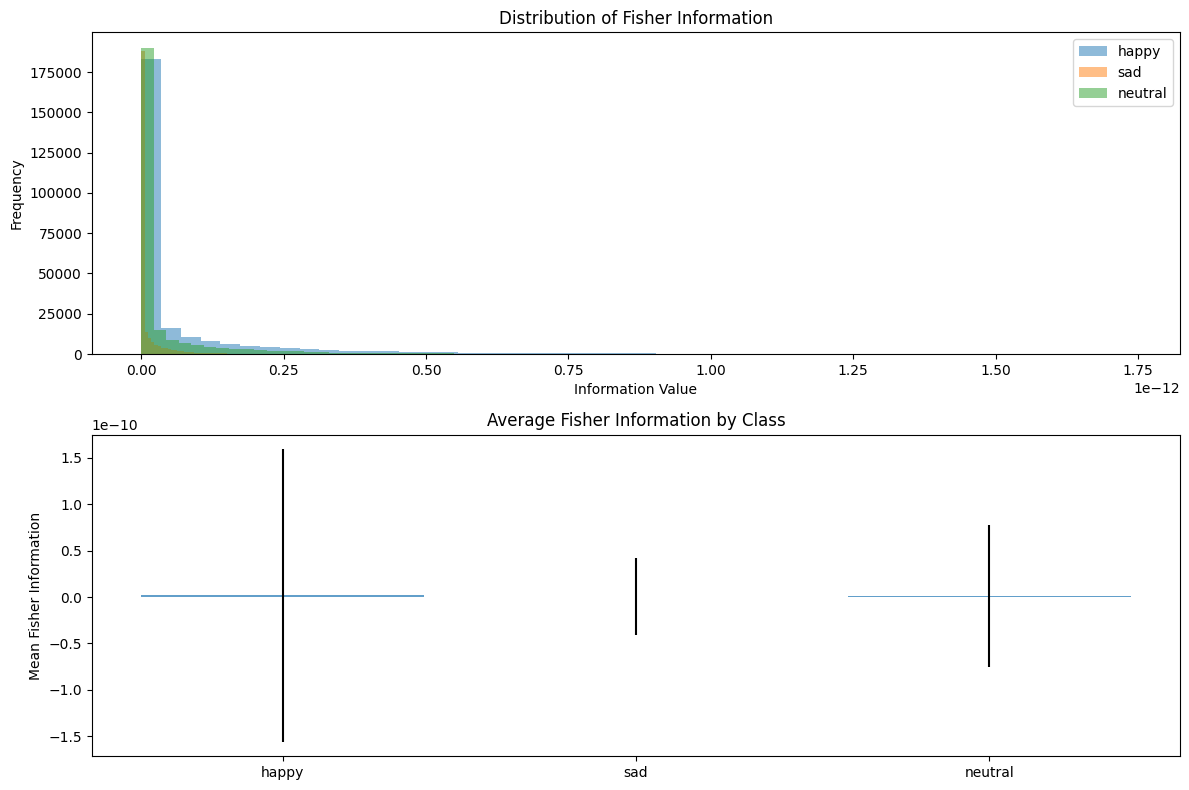

Computing Cramer-Rao bounds...


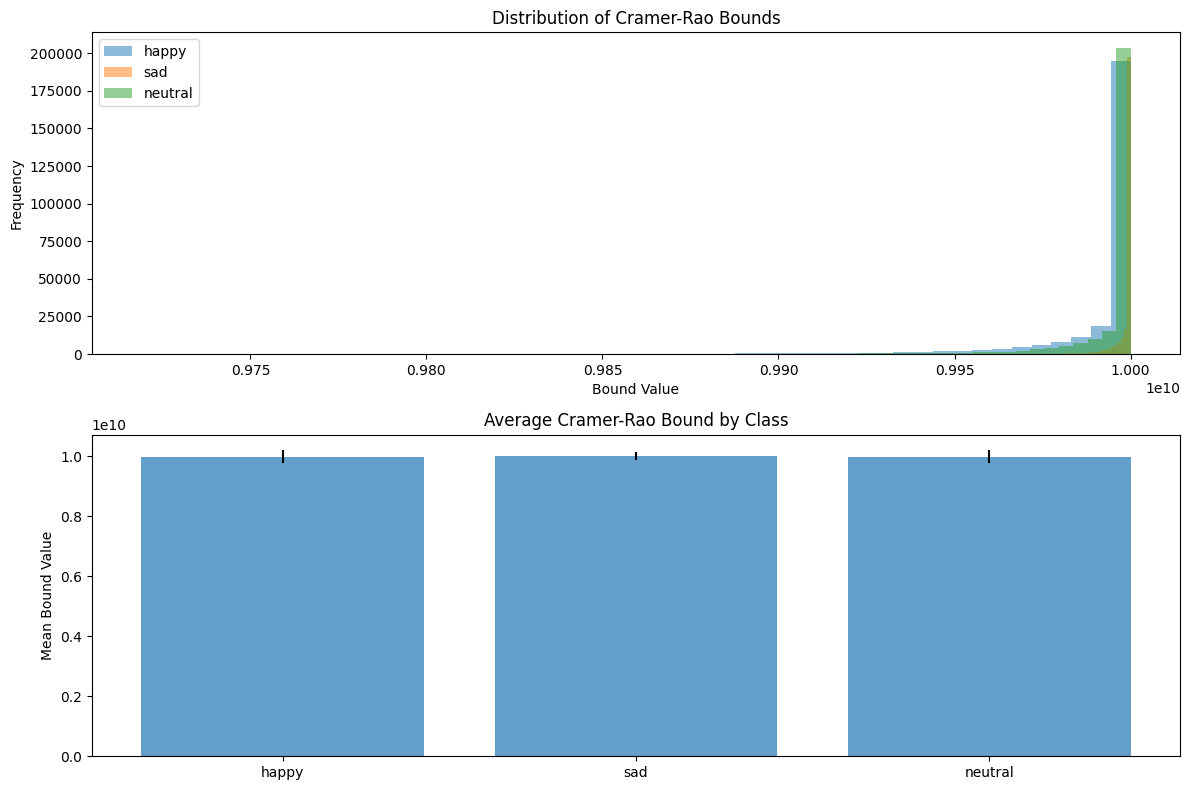

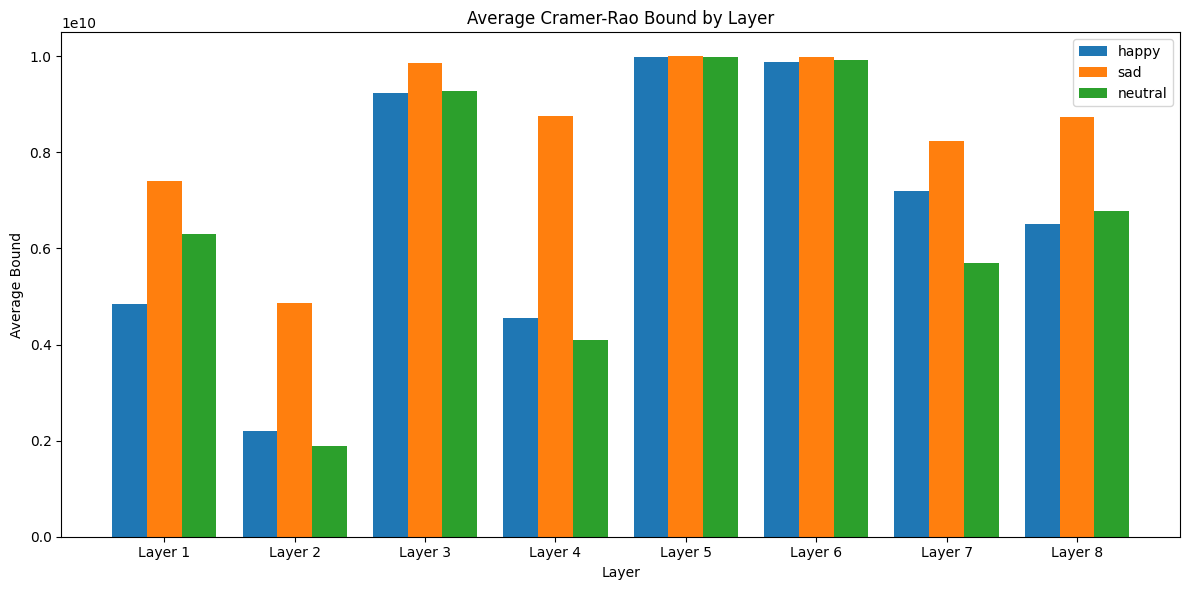

Computing parameter importance for unlearning...


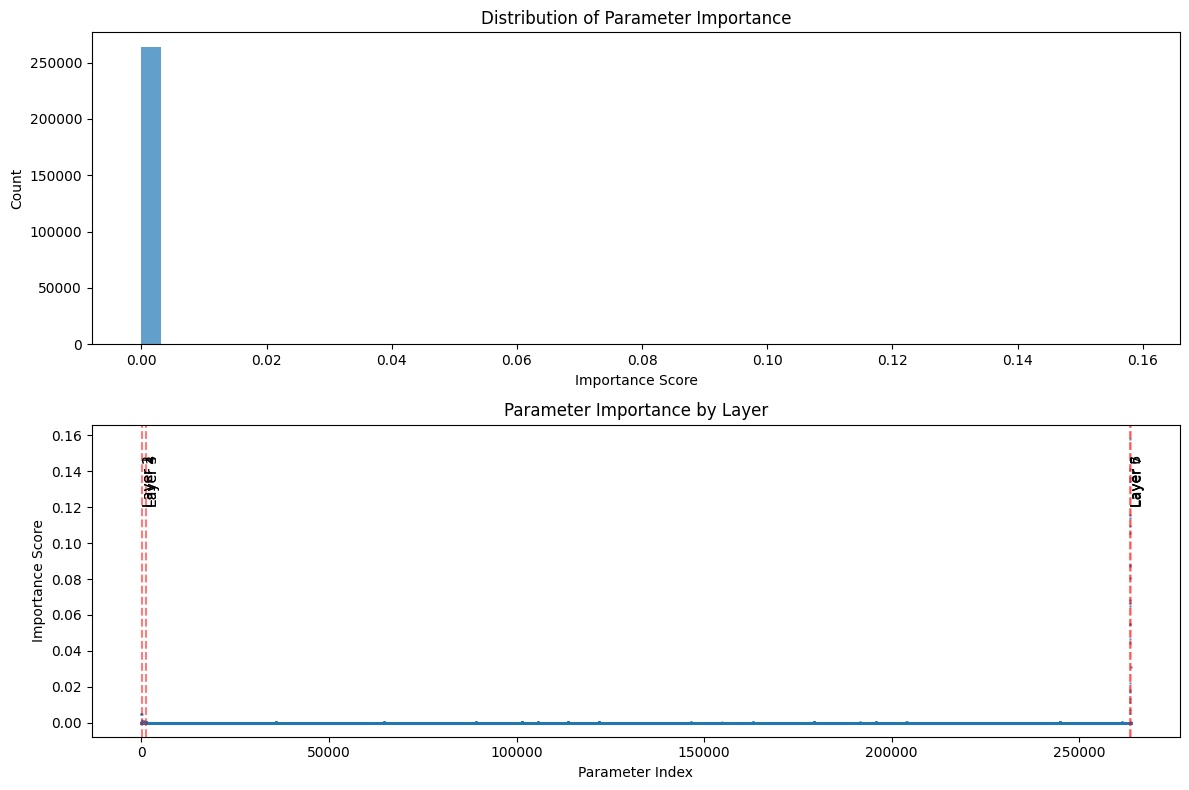


Evaluating original model...

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=1.0, threshold=0.1

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=1.0, threshold=0.2

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=1.0, threshold=0.3

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=1.0, threshold=0.4

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=1.0, threshold=0.5

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=2.0, threshold=0.1

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=2.0, threshold=0.2

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=2.0, threshold=0.3

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=2.0, threshold=0.4

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000

Trying noise=2.0, thre

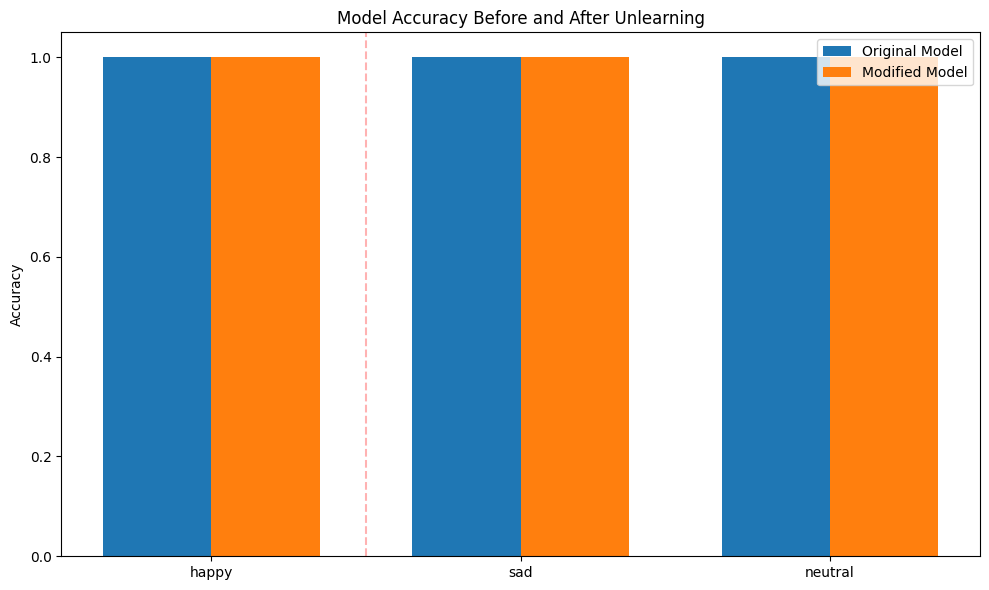

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import copy

# ===============================================================
# Simplified Fisher Information Computation
# ===============================================================

def compute_simple_fisher(model, dataloader, criterion):
    """
    Simplified computation of diagonal Fisher Information Matrix.
    This is more memory-efficient and faster than the per-sample approach.

    Args:
        model: PyTorch model
        dataloader: DataLoader for the dataset
        criterion: Loss function

    Returns:
        List of diagonal Fisher matrices (one per layer)
    """
    model.eval()  # Set model to evaluation mode
    fisher_diag = [torch.zeros_like(p) for p in model.parameters()]

    num_samples = 0
    print("Computing Fisher Information...")

    # Process mini-batches
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if batch_idx % 5 == 0:
            print(f"Processing batch {batch_idx}/{len(dataloader)}")

        batch_size = inputs.size(0)
        num_samples += batch_size

        # Forward pass
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Accumulate Fisher Information (squared gradients)
        for i, param in enumerate(model.parameters()):
            if param.grad is not None:
                fisher_diag[i] += param.grad.data.pow(2) * batch_size

    # Normalize by the number of samples
    for i in range(len(fisher_diag)):
        fisher_diag[i] /= num_samples

    return fisher_diag

# ===============================================================
# Core Unlearning Functions
# ===============================================================

def compute_unlearning_importance(fisher_full, fisher_without_class, epsilon=1e-8):
    """
    Calculate parameter importance for unlearning based on Fisher Information

    Args:
        fisher_full: Fisher Information matrix from full dataset
        fisher_without_class: Fisher Information matrix without class to forget
        epsilon: Small number for numerical stability

    Returns:
        List of importance scores for each parameter
    """
    importance = []

    for f_full, f_without in zip(fisher_full, fisher_without_class):
        # Information contribution from the class to forget
        # We use a simple difference normalized by the full Fisher
        diff = (f_full - f_without)
        norm_diff = diff / (f_full + epsilon)

        # Clip to [0, 1] and handle numerical issues
        norm_diff = torch.clamp(norm_diff, 0.0, 1.0)
        norm_diff = torch.nan_to_num(norm_diff)

        importance.append(norm_diff)

    return importance

def apply_selective_forgetting(model, importance, noise_scale=2.0, threshold=0.3):
    """
    Apply selective noise to parameters based on their importance

    Args:
        model: PyTorch model
        importance: List of importance scores for each parameter
        noise_scale: Scale of noise to apply
        threshold: Minimum importance threshold to apply noise

    Returns:
        Modified model
    """
    modified_model = copy.deepcopy(model)

    with torch.no_grad():
        for param, imp in zip(modified_model.parameters(), importance):
            # Only apply noise to parameters above threshold importance
            mask = (imp > threshold).float()

            # Scale noise by parameter magnitude
            param_scale = param.abs().mean().item()
            noise = torch.randn_like(param) * param_scale * noise_scale

            # Apply selective noise
            param.add_(noise * mask)

    return modified_model

# ===============================================================
# Cramer-Rao Bound Calculation
# ===============================================================

def compute_cramer_rao_bound(fisher_diag, epsilon=1e-10):
    """
    Compute the Cramer-Rao lower bound on parameter variance

    Args:
        fisher_diag: Diagonal of Fisher Information Matrix
        epsilon: Small constant for numerical stability

    Returns:
        Cramer-Rao bound (inverse of Fisher)
    """
    cramer_rao = []
    for f in fisher_diag:
        # The Cramer-Rao bound is the inverse of the Fisher Information
        # For a diagonal approximation, we just invert each entry
        cr = 1.0 / (f + epsilon)
        cramer_rao.append(cr)

    return cramer_rao

def visualize_cramer_rao(cramer_rao_bounds, labels=None):
    """
    Visualize Cramer-Rao bounds for different models/datasets

    Args:
        cramer_rao_bounds: Dict mapping labels to Cramer-Rao bounds
        labels: Optional custom labels
    """
    if labels is None:
        labels = list(cramer_rao_bounds.keys())

    plt.figure(figsize=(12, 8))

    # Flatten all bounds for comparison
    flattened_bounds = {}
    for name, bounds in cramer_rao_bounds.items():
        values = []
        for bound in bounds:
            flat = bound.flatten().cpu().numpy()
            # Filter out extreme values for better visualization
            flat = flat[~np.isinf(flat)]
            flat = flat[~np.isnan(flat)]
            values.append(flat)
        flattened_bounds[name] = np.concatenate(values)

    # Plot histograms
    plt.subplot(2, 1, 1)
    for name, values in flattened_bounds.items():
        # Get the middle 99% of values (remove extremes)
        low, high = np.percentile(values, [0.5, 99.5])
        filtered = values[(values >= low) & (values <= high)]
        plt.hist(filtered, bins=50, alpha=0.5, label=name)

    plt.title('Distribution of Cramer-Rao Bounds')
    plt.xlabel('Bound Value')
    plt.ylabel('Frequency')
    plt.legend()

    # Plot class-wise statistics instead of layer-wise
    plt.subplot(2, 1, 2)

    # Calculate mean and std for each class
    class_means = [np.nanmean(flattened_bounds[name]) for name in labels]
    class_stds = [np.nanstd(flattened_bounds[name]) for name in labels]

    x = np.arange(len(labels))
    plt.bar(x, class_means, yerr=class_stds, alpha=0.7)
    plt.xticks(x, labels)
    plt.title('Average Cramer-Rao Bound by Class')
    plt.ylabel('Mean Bound Value')

    plt.tight_layout()
    plt.show()

    # Create a separate figure for layer-wise visualization
    # Determine the number of layers (use the first class as reference)
    first_class = list(cramer_rao_bounds.keys())[0]
    num_layers = len(cramer_rao_bounds[first_class])

    plt.figure(figsize=(12, 6))
    x = np.arange(num_layers)
    width = 0.8 / len(labels)

    for i, name in enumerate(labels):
        # Calculate mean for each layer
        layer_means = [np.nanmean(cramer_rao_bounds[name][j].cpu().numpy()) for j in range(num_layers)]
        plt.bar(x + i*width - 0.4 + width/2, layer_means, width, label=name)

    plt.title('Average Cramer-Rao Bound by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Average Bound')
    plt.xticks(x, [f'Layer {i+1}' for i in range(num_layers)])
    plt.legend()

    plt.tight_layout()
    plt.show()

# ===============================================================
# Fisher Information Visualization
# ===============================================================

def fisher_information_heatmap(fisher_matrices, class_names, model):
    """
    Generate heatmap visualizations of Fisher Information for different classes

    Args:
        fisher_matrices: Dictionary mapping class names to Fisher matrices
        class_names: List of class names
        model: PyTorch model (for parameter shapes)
    """
    # Get parameter shapes
    param_shapes = [p.shape for p in model.parameters()]
    layer_names = [f"Layer {i+1}" for i in range(len(param_shapes))]

    # Create a figure with subplots for each class and layer
    fig, axes = plt.subplots(len(class_names), min(len(param_shapes), 4),
                            figsize=(15, 3*len(class_names)))

    # Handle single layer or single class case
    if len(class_names) == 1 and min(len(param_shapes), 4) == 1:
        axes = np.array([[axes]])
    elif len(class_names) == 1:
        axes = np.array([axes])
    elif min(len(param_shapes), 4) == 1:
        axes = np.array([[ax] for ax in axes])

    # Plot only the first 4 layers to keep the visualization manageable
    layers_to_plot = min(len(param_shapes), 4)

    # Plot heatmaps for each class and layer
    for i, class_name in enumerate(class_names):
        for j in range(layers_to_plot):
            ax = axes[i, j]

            # Get Fisher information for this class and layer
            if class_name in fisher_matrices:
                # For large tensors, just show a 2D slice
                fisher = fisher_matrices[class_name][j]

                # Convert to 2D for visualization
                if len(fisher.shape) == 1:  # 1D tensor
                    n = fisher.numel()
                    # Find largest square that fits in the tensor
                    size = int(np.floor(np.sqrt(n)))
                    # Use reshape instead of view and ensure we don't exceed tensor size
                    fisher_2d = fisher[:size*size].reshape(size, size)
                elif len(fisher.shape) == 2:  # Already 2D
                    fisher_2d = fisher
                else:  # Higher dimensional
                    # Take mean across all but last 2 dimensions
                    fisher_2d = fisher.mean(dim=tuple(range(len(fisher.shape)-2)))

                # Plot
                im = ax.imshow(fisher_2d.detach().cpu().numpy(), cmap='viridis')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"{class_name} - {layer_names[j]}")

                # Add colorbar
                plt.colorbar(im, ax=ax)
            else:
                ax.text(0.5, 0.5, "No Data", ha='center', va='center')
                ax.set_title(f"{class_name} - {layer_names[j]}")
                ax.set_xticks([])
                ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def plot_fisher_comparison(fisher_matrices, class_names):
    """
    Compare Fisher Information for different classes

    Args:
        fisher_matrices: Dictionary mapping class names to Fisher matrices
        class_names: List of class names to compare
    """
    plt.figure(figsize=(12, 8))

    # Flatten all Fisher matrices for comparison
    flattened_fisher = {}
    for name in class_names:
        if name in fisher_matrices:
            fisher = fisher_matrices[name]
            values = []
            for f in fisher:
                flat = f.flatten().cpu().numpy()
                flat = flat[~np.isinf(flat)]
                flat = flat[~np.isnan(flat)]
                values.append(flat)
            flattened_fisher[name] = np.concatenate(values)

    # Plot histograms
    plt.subplot(2, 1, 1)
    for name, values in flattened_fisher.items():
        # Get the middle 98% of values (remove extremes)
        low, high = np.percentile(values, [1, 99])
        filtered = values[(values >= low) & (values <= high)]
        plt.hist(filtered, bins=50, alpha=0.5, label=name)

    plt.title('Distribution of Fisher Information')
    plt.xlabel('Information Value')
    plt.ylabel('Frequency')
    plt.legend()

    # Plot statistics
    plt.subplot(2, 1, 2)
    names = list(flattened_fisher.keys())
    means = [np.mean(flattened_fisher[name]) for name in names]
    stds = [np.std(flattened_fisher[name]) for name in names]

    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, alpha=0.7)
    plt.xticks(x, names)
    plt.title('Average Fisher Information by Class')
    plt.ylabel('Mean Fisher Information')

    plt.tight_layout()
    plt.show()

# ===============================================================
# Evaluation Functions
# ===============================================================

def evaluate_model(model, dataloaders, class_names):
    """
    Evaluate model accuracy on multiple datasets

    Args:
        model: PyTorch model
        dataloaders: Dict of dataloaders for different classes
        class_names: List of class names

    Returns:
        Dict of accuracy scores
    """
    model.eval()
    results = {}

    for class_name, dataloader in dataloaders.items():
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in dataloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        results[class_name] = correct / total if total > 0 else 0

    # Print results
    print("\nModel Accuracy:")
    for class_name, acc in results.items():
        print(f"  {class_name}: {acc:.4f}")

    return results

def visualize_importance(importance, model):
    """
    Visualize parameter importance for unlearning

    Args:
        importance: List of importance values per parameter
        model: PyTorch model (for parameter names)
    """
    plt.figure(figsize=(12, 8))

    # Prepare data for plotting
    all_values = []
    layer_boundaries = [0]
    param_count = 0

    for i, imp in enumerate(importance):
        imp_flat = imp.flatten().cpu().numpy()
        all_values.append(imp_flat)
        param_count += len(imp_flat)
        layer_boundaries.append(param_count)

    all_values_flat = np.concatenate(all_values)

    # Plot overall distribution
    plt.subplot(2, 1, 1)
    plt.hist(all_values_flat, bins=50, alpha=0.7)
    plt.title("Distribution of Parameter Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Count")

    # Plot importance by layer
    plt.subplot(2, 1, 2)
    x = np.arange(len(all_values_flat))
    plt.scatter(x, all_values_flat, s=1, alpha=0.5)
    plt.title("Parameter Importance by Layer")
    plt.xlabel("Parameter Index")
    plt.ylabel("Importance Score")

    # Add layer boundaries
    for i, boundary in enumerate(layer_boundaries[1:-1], 1):
        plt.axvline(x=boundary, color='r', linestyle='--', alpha=0.3)
        plt.text(boundary, plt.ylim()[1]*0.9, f"Layer {i}",
                 rotation=90, verticalalignment='top')

    plt.tight_layout()
    plt.show()

# ===============================================================
# Main Unlearning Pipeline
# ===============================================================

def unlearn_class(model, class_datasets, criterion, class_to_forget=1, batch_size=32, include_cramer_rao=True):
    """
    Main pipeline for unlearning a specific class

    Args:
        model: Trained PyTorch model
        class_datasets: Dict of datasets for each class
        criterion: Loss function
        class_to_forget: Index of class to forget
        batch_size: Batch size for data loading

    Returns:
        Dict containing results and modified model
    """
    # 1. Prepare datasets
    print("Preparing datasets...")
    class_names = list(class_datasets.keys())

    # Create full dataset and dataset without the class to forget
    forget_class_name = class_names[class_to_forget]
    keep_datasets = {name: ds for name, ds in class_datasets.items() if name != forget_class_name}

    full_dataset = torch.utils.data.ConcatDataset(list(class_datasets.values()))
    keep_dataset = torch.utils.data.ConcatDataset(list(keep_datasets.values()))

    # Create dataloaders
    dataloaders = {}
    for name, dataset in class_datasets.items():
        dataloaders[name] = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
    keep_loader = DataLoader(keep_dataset, batch_size=batch_size, shuffle=False)

    # 2. Compute Fisher Information
    print(f"Computing Fisher Information for full dataset...")
    fisher_full = compute_simple_fisher(model, full_loader, criterion)

    print(f"Computing Fisher Information without '{forget_class_name}'...")
    fisher_without = compute_simple_fisher(model, keep_loader, criterion)

    # Compute class-specific Fisher Information (optional)
    fisher_per_class = {}
    for name, loader in dataloaders.items():
        print(f"Computing Fisher Information for class '{name}'...")
        fisher_per_class[name] = compute_simple_fisher(model, loader, criterion)

    # Visualize Fisher Information
    print("Generating Fisher Information visualizations...")
    fisher_information_heatmap(fisher_per_class, class_names, model)
    plot_fisher_comparison(fisher_per_class, class_names)

    # 3. Compute Cramer-Rao bounds (if requested)
    if include_cramer_rao:
        print("Computing Cramer-Rao bounds...")
        cr_bound_full = compute_cramer_rao_bound(fisher_full)
        cr_bound_without = compute_cramer_rao_bound(fisher_without)

        cr_bounds_per_class = {}
        for name, fisher in fisher_per_class.items():
            cr_bounds_per_class[name] = compute_cramer_rao_bound(fisher)

        # Visualize Cramer-Rao bounds
        visualize_cramer_rao(cr_bounds_per_class)

    # 4. Compute unlearning importance
    print("Computing parameter importance for unlearning...")
    importance = compute_unlearning_importance(fisher_full, fisher_without)

    # 4. Visualize importance
    visualize_importance(importance, model)

    # 5. Evaluate original model
    print("\nEvaluating original model...")
    original_accuracy = evaluate_model(model, dataloaders, class_names)

    # 6. Apply selective forgetting with different parameters
    results = []
    best_model = None
    best_score = -float('inf')

    noise_levels = [1.0, 2.0, 3.0, 5.0]
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

    for noise in noise_levels:
        for threshold in thresholds:
            print(f"\nTrying noise={noise}, threshold={threshold}")

            # Apply forgetting
            modified_model = apply_selective_forgetting(
                model, importance, noise_scale=noise, threshold=threshold)

            # Evaluate
            modified_accuracy = evaluate_model(modified_model, dataloaders, class_names)

            # Calculate forgetting effectiveness score
            # We want to maximize accuracy on classes to keep while minimizing on class to forget
            keep_acc = np.mean([modified_accuracy[name] for name in keep_datasets.keys()])
            forget_acc = modified_accuracy[forget_class_name]

            # Forgetting score: high for good keep accuracy and low forget accuracy
            score = keep_acc - forget_acc

            # Store results
            results.append({
                'noise': noise,
                'threshold': threshold,
                'accuracy': modified_accuracy,
                'keep_acc': keep_acc,
                'forget_acc': forget_acc,
                'score': score
            })

            # Update best model
            if score > best_score and keep_acc > 0.7:  # Ensure reasonable performance
                best_score = score
                best_model = copy.deepcopy(modified_model)

    # 7. Show best results
    print("\nBest unlearning results:")
    best_result = max(results, key=lambda x: x['score'])
    print(f"  Noise scale: {best_result['noise']}")
    print(f"  Threshold: {best_result['threshold']}")
    print(f"  Keep accuracy: {best_result['keep_acc']:.4f}")
    print(f"  Forget accuracy: {best_result['forget_acc']:.4f}")
    print(f"  Score: {best_result['score']:.4f}")

    # 8. Plot comparison of original vs best modified model
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.35

    # Original model accuracy
    original_acc = [original_accuracy[name] for name in class_names]
    plt.bar(x - width/2, original_acc, width, label='Original Model')

    # Best modified model accuracy
    best_acc = [best_result['accuracy'][name] for name in class_names]
    plt.bar(x + width/2, best_acc, width, label='Modified Model')

    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Before and After Unlearning')
    plt.xticks(x, class_names)
    plt.axvline(x=class_to_forget - 0.5, color='r', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return results
    result_dict = {
        'original_model': model,
        'modified_model': best_model,
        'importance': importance,
        'results': results,
        'best_result': best_result,
        'fisher_full': fisher_full,
        'fisher_without': fisher_without,
        'fisher_per_class': fisher_per_class
    }

    # Add Cramer-Rao bounds if computed
    if include_cramer_rao:
        result_dict.update({
            'cr_bound_full': cr_bound_full,
            'cr_bound_without': cr_bound_without,
            'cr_bounds_per_class': cr_bounds_per_class
        })

    return result_dict

# ===============================================================
# Example Usage
# ===============================================================

# Assuming you have datasets for each class
happy_dataset = TensorDataset(images_h, labels_h)
sad_dataset = TensorDataset(images_s, labels_s)
neutral_dataset = TensorDataset(images_n, labels_n)

class_datasets = {
    'happy': happy_dataset,
    'sad': sad_dataset,
    'neutral': neutral_dataset
}

# Define loss function
criterion = nn.CrossEntropyLoss()

# Run unlearning pipeline
results = unlearn_class(
    model=model,
    class_datasets=class_datasets,
    criterion=criterion,
    class_to_forget=1  # Sad faces (index 1)
)

# Access the unlearned model
unlearned_model = results['modified_model']


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math

def robust_fisher_heatmap(fisher_matrices, class_names, model):
    """
    Generate heatmap visualizations of Fisher Information for different classes.
    This version is more robust to different tensor shapes and sizes.

    Args:
        fisher_matrices: Dictionary mapping class names to Fisher matrices
        class_names: List of class names
        model: PyTorch model (for parameter shapes)
    """
    # Count total number of layers
    num_layers = len(list(model.parameters()))

    # Create layer names
    layer_names = []
    for i, p in enumerate(model.parameters()):
        if len(p.shape) >= 2:  # Conv or Linear
            layer_type = "Conv" if len(p.shape) == 4 else "Linear"
            layer_names.append(f"{layer_type} {i+1}")
        else:  # Bias or other 1D param
            layer_names.append(f"Bias {i+1}")

    # Create a more compact visualization - one plot per class
    for class_name in class_names:
        if class_name not in fisher_matrices:
            continue

        print(f"Visualizing Fisher Information for class: {class_name}")
        fisher = fisher_matrices[class_name]

        # Calculate how many subplots we need
        subplot_cols = min(4, num_layers)
        subplot_rows = math.ceil(num_layers / subplot_cols)

        # Create figure
        fig = plt.figure(figsize=(5*subplot_cols, 4*subplot_rows))
        fig.suptitle(f"Fisher Information: {class_name}", fontsize=16)

        # For each layer
        for i, layer_fisher in enumerate(fisher):
            # Skip if tensor is empty
            if layer_fisher.numel() == 0:
                continue

            # Create subplot
            ax = fig.add_subplot(subplot_rows, subplot_cols, i+1)

            # Determine how to visualize based on shape
            if len(layer_fisher.shape) == 1:  # 1D - bias or similar
                # Just plot as bar chart for 1D
                values = layer_fisher.detach().cpu().numpy()
                ax.bar(range(len(values)), values)
                ax.set_title(f"{layer_names[i]} (1D)")

            elif len(layer_fisher.shape) == 2:  # 2D - weights of linear layer
                # Direct 2D heatmap
                values = layer_fisher.detach().cpu().numpy()
                im = ax.imshow(values, cmap='viridis', norm=LogNorm(vmin=max(values.min(), 1e-10)))
                ax.set_title(f"{layer_names[i]} {values.shape}")
                plt.colorbar(im, ax=ax)

            elif len(layer_fisher.shape) == 4:  # 4D - conv weights
                # For 4D, take mean across input/output channels
                # Shape is typically [out_channels, in_channels, kernel_h, kernel_w]
                values = layer_fisher.mean(dim=(0, 1)).detach().cpu().numpy()
                im = ax.imshow(values, cmap='viridis')
                ax.set_title(f"{layer_names[i]} Kernels (mean)")
                plt.colorbar(im, ax=ax)

            else:  # Other shapes
                # Flatten and show distribution
                values = layer_fisher.flatten().detach().cpu().numpy()
                ax.hist(values, bins=50)
                ax.set_title(f"{layer_names[i]} {layer_fisher.shape} (hist)")

            # Hide ticks for cleaner look on heatmaps
            if len(layer_fisher.shape) >= 2:
                ax.set_xticks([])
                ax.set_yticks([])

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Make room for title
        plt.show()

def plot_importance_by_layer(importance, model):
    """
    Plot the unlearning importance values for each layer in the model

    Args:
        importance: List of importance tensors per layer
        model: PyTorch model
    """
    # Get layer names
    layer_names = []
    for i, p in enumerate(model.parameters()):
        shape_str = 'x'.join(str(x) for x in p.shape)
        layer_names.append(f"Layer {i+1} ({shape_str})")

    # Prepare figure
    fig, axes = plt.subplots(len(importance), 1, figsize=(10, 3*len(importance)))

    # Handle single layer case
    if len(importance) == 1:
        axes = [axes]

    # Plot each layer's importance
    layer_means = []
    layer_maxes = []

    for i, (imp, name) in enumerate(zip(importance, layer_names)):
        # Get stats
        imp_np = imp.detach().cpu().numpy().flatten()
        mean_val = np.mean(imp_np)
        max_val = np.max(imp_np)
        layer_means.append(mean_val)
        layer_maxes.append(max_val)

        # Plot histogram
        axes[i].hist(imp_np, bins=50, alpha=0.7)
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.4f}')
        axes[i].set_title(name)
        axes[i].set_xlabel('Importance Score')
        axes[i].set_ylabel('Count')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    # Summary plot
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(layer_names))
    plt.bar(indices, layer_means, alpha=0.7, label='Mean Importance')
    plt.plot(indices, layer_maxes, 'ro-', label='Max Importance')
    plt.xticks(indices, [f"Layer {i+1}" for i in range(len(layer_names))], rotation=45)
    plt.xlabel('Layer')
    plt.ylabel('Importance Score')
    plt.title('Layer-wise Unlearning Importance')
    plt.legend()
    plt.tight_layout()
    plt.show()

Visualizing Fisher Information for class: happy


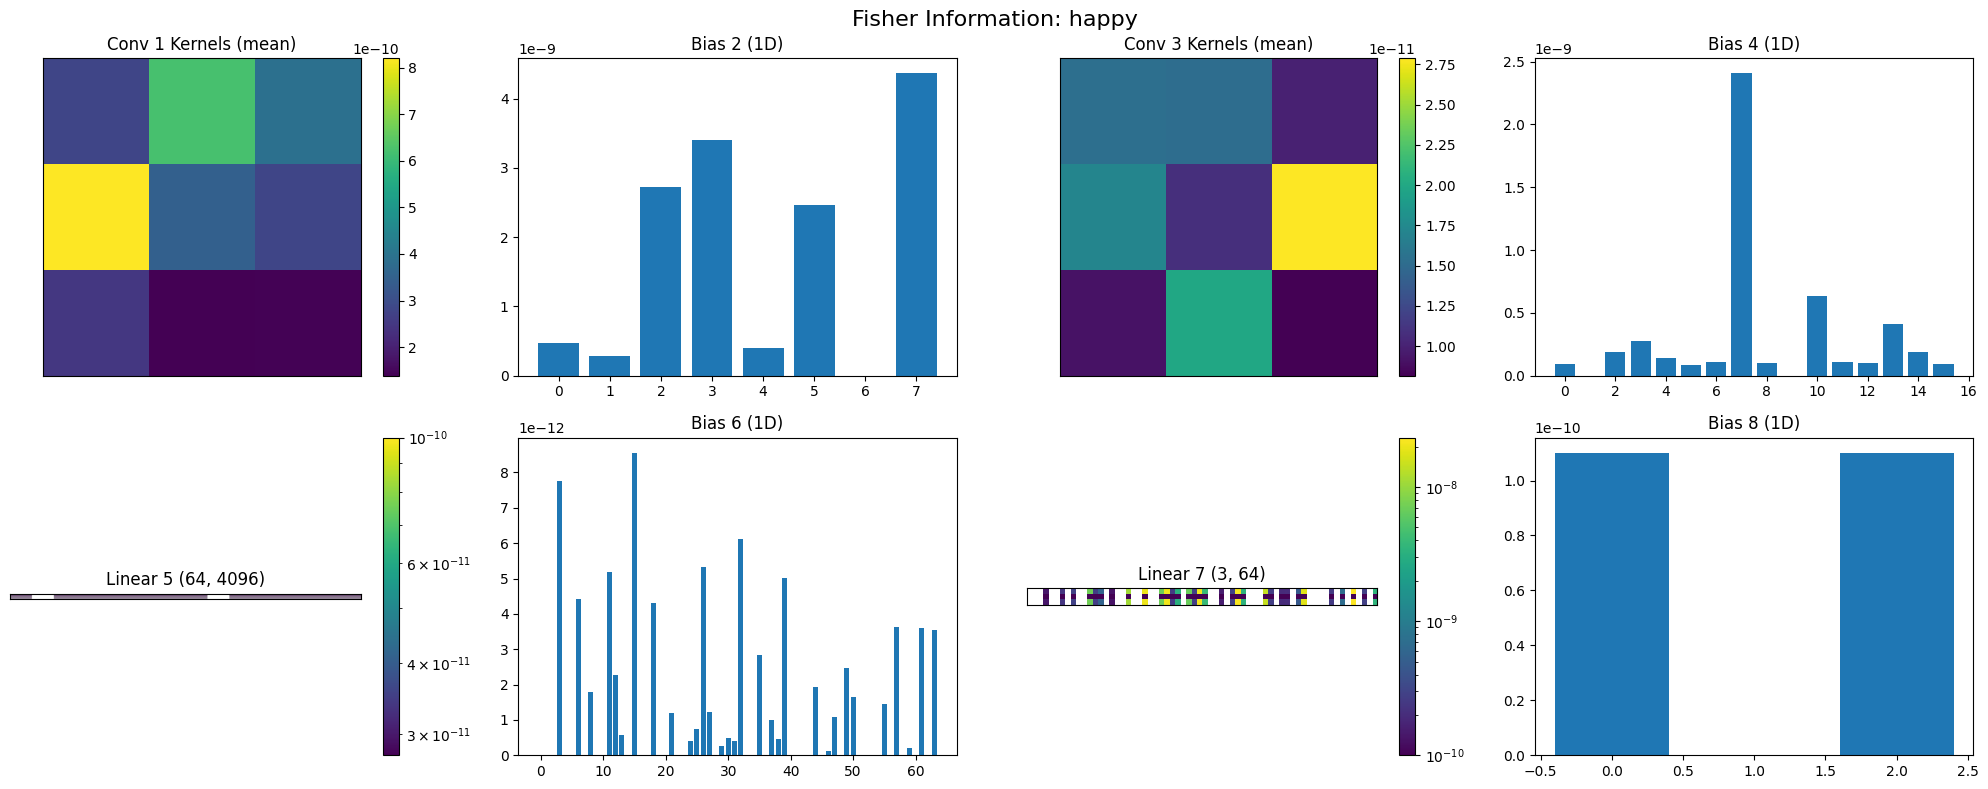

Visualizing Fisher Information for class: sad


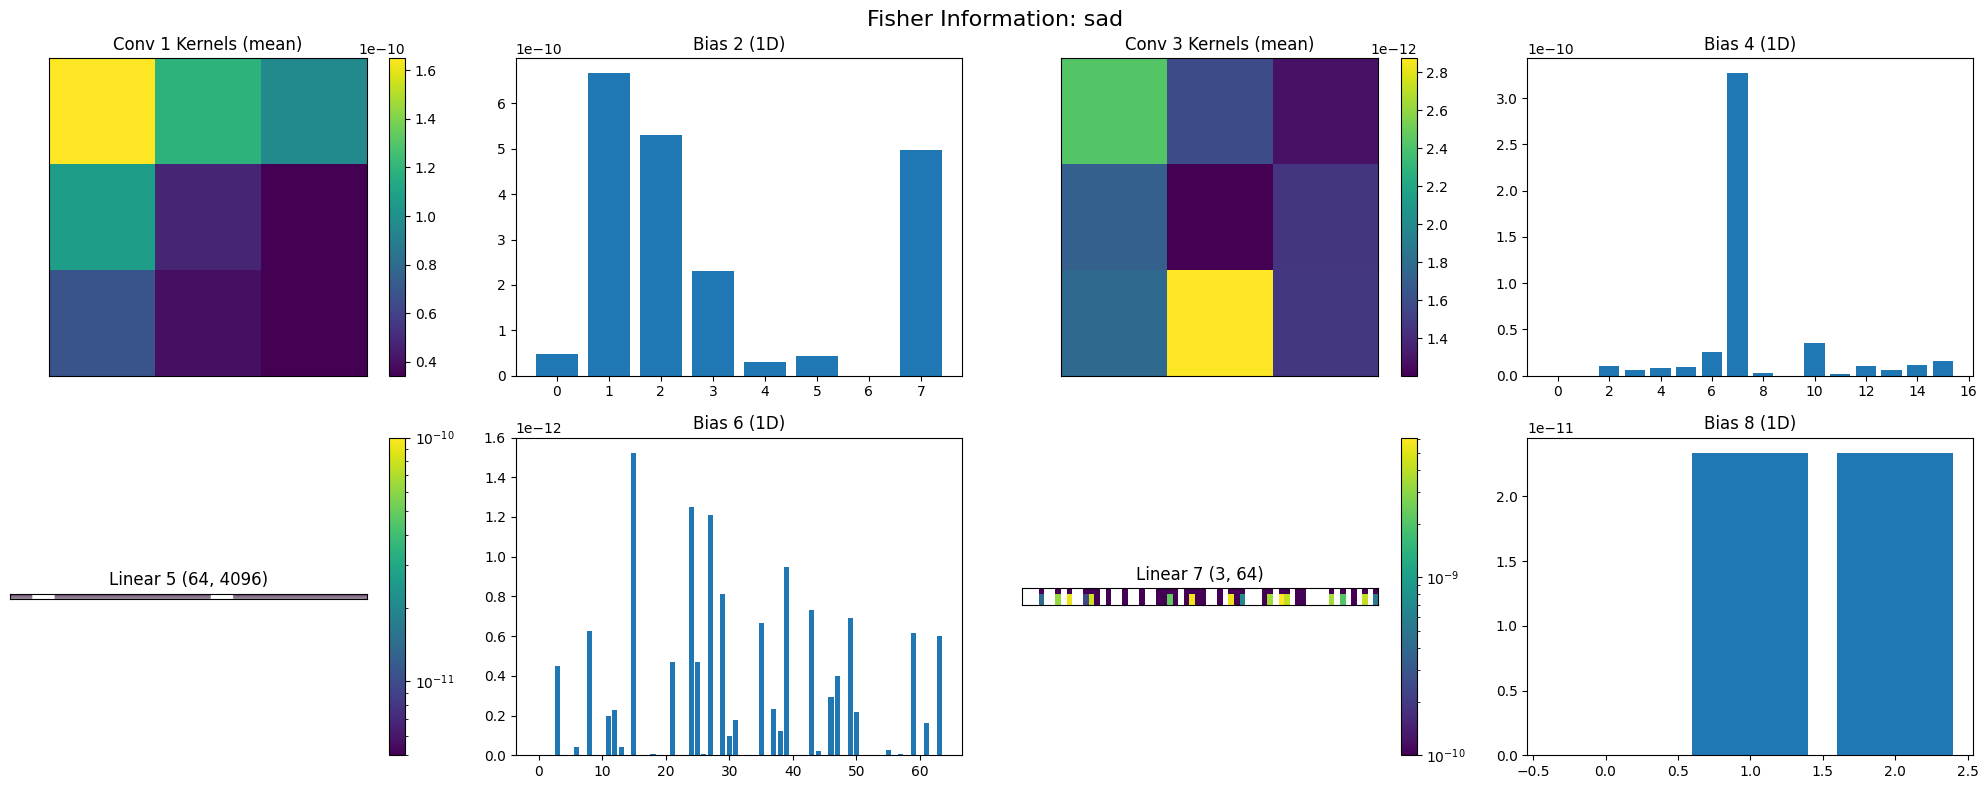

Visualizing Fisher Information for class: neutral


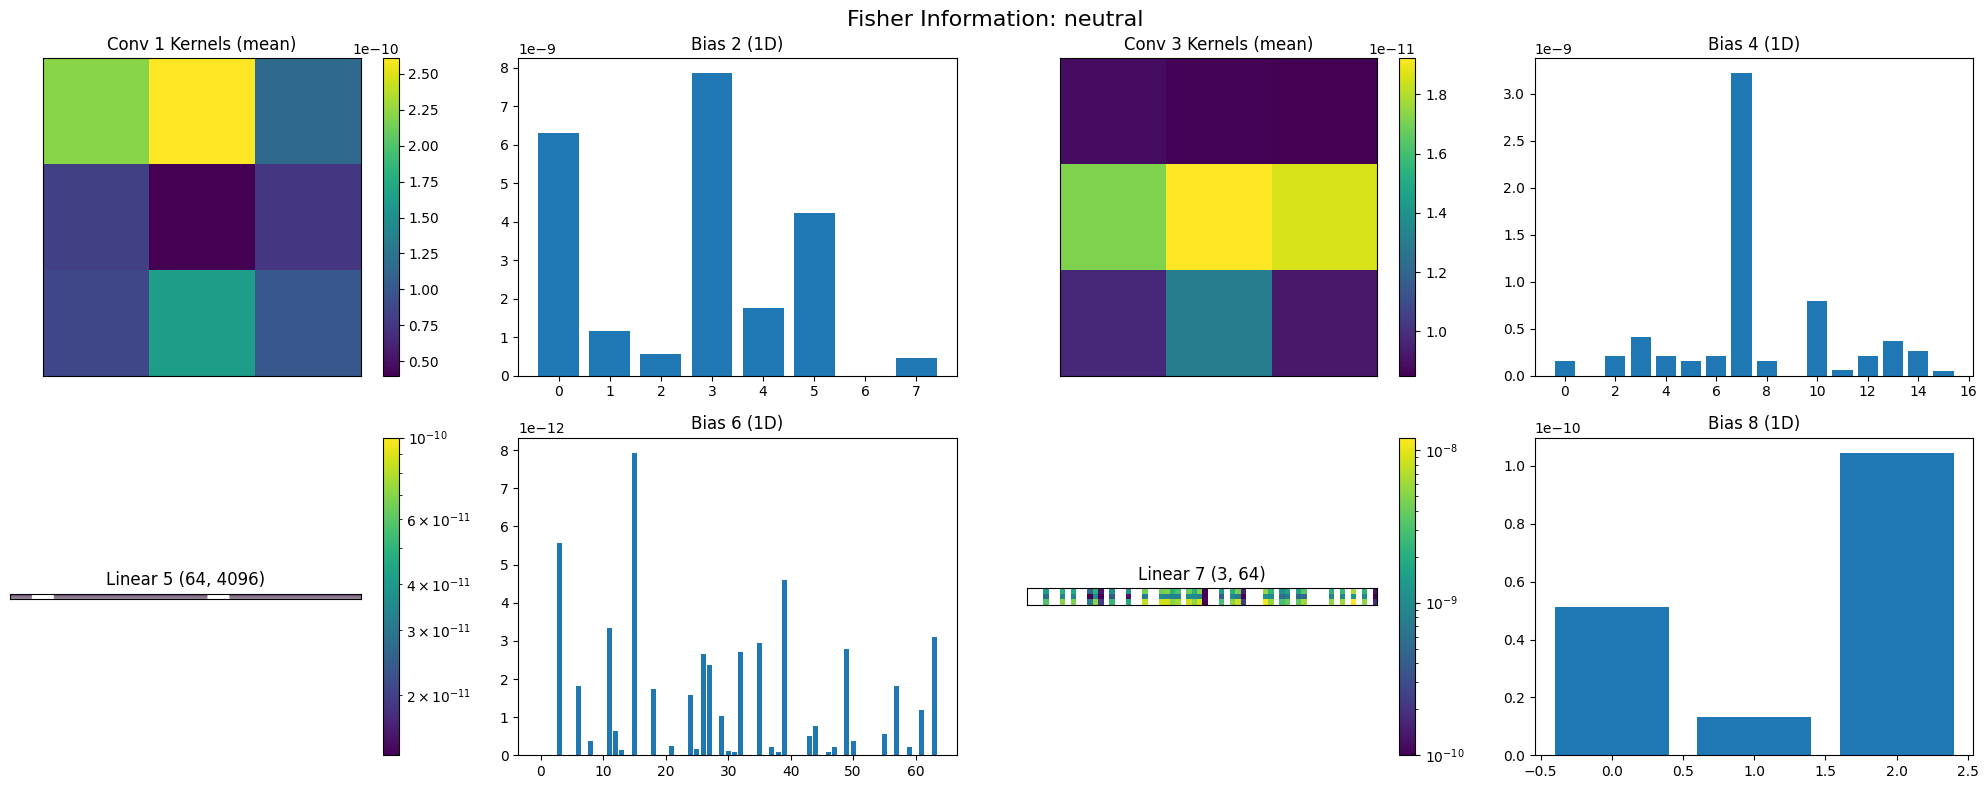

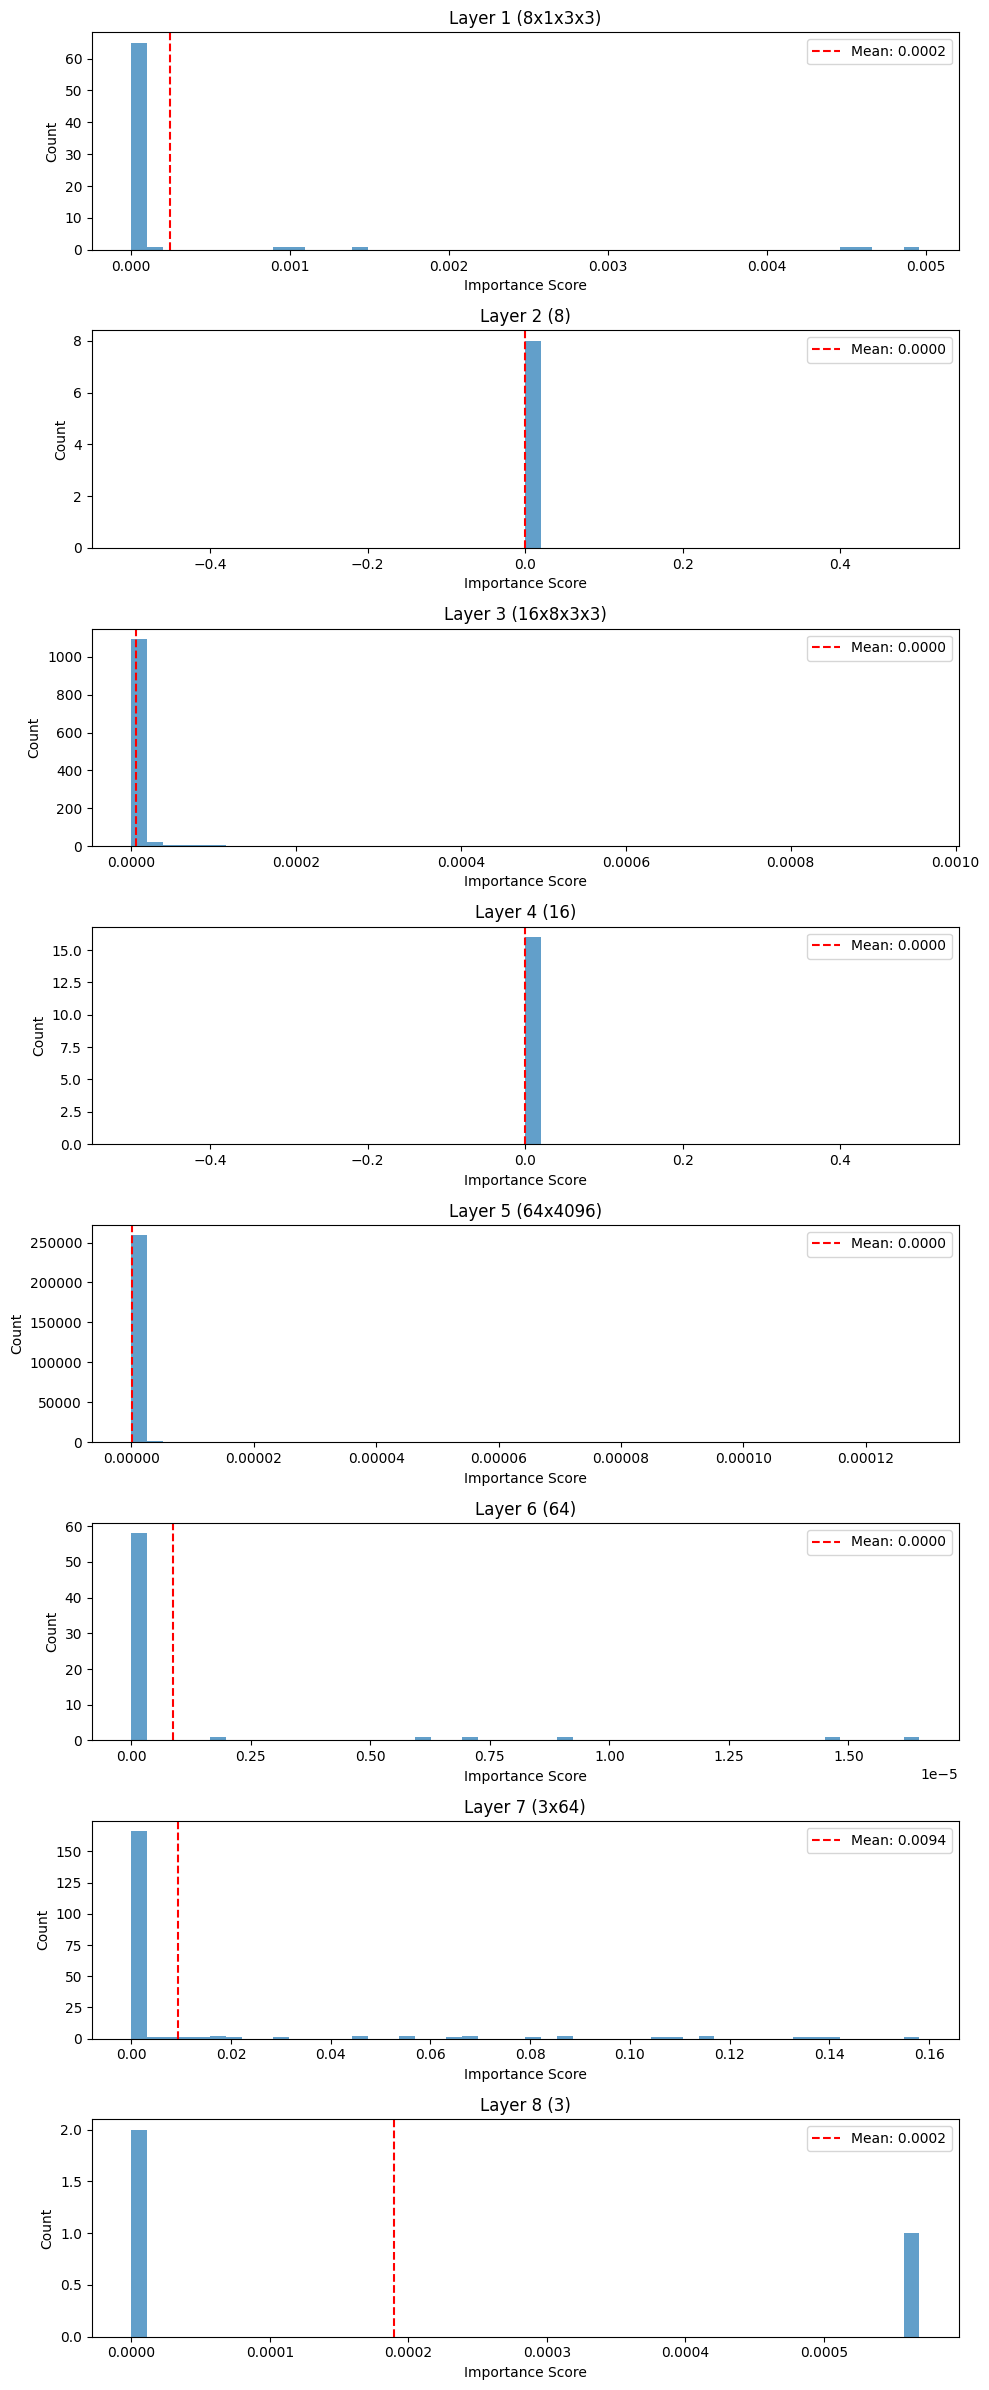

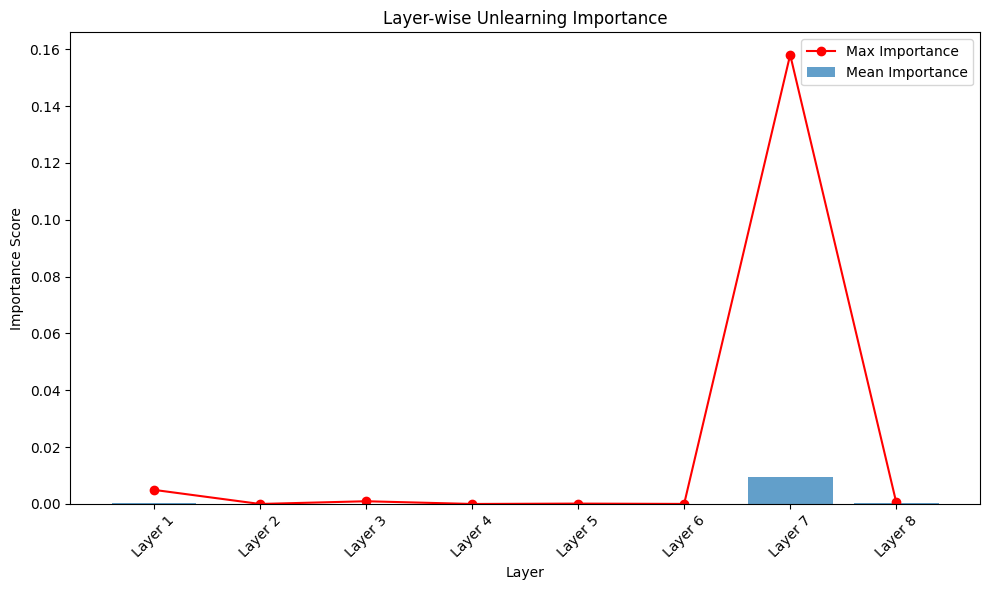

In [14]:
robust_fisher_heatmap(results["fisher_per_class"], list(class_datasets.keys()), model)

# Visualize importance scores by layer
plot_importance_by_layer(results["importance"], model)